In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
import requests

from utils.data import SlidingWindowDataset, get_Electricity_Transformer_Temperature_dataset, get_Electricity_Consuming_Load_dataset

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
%load_ext autoreload
%autoreload 2

# Train, val, test size

In [29]:
val_size = 0.15 # samples
test_size = 0.15 # samples 

input_size = 336
horizont_size = 168

In [ ]:
from torch.utils.data import Dataset


class SlidingWindowDataset(Dataset):
    def __init__(self, ts, window_size, step_size):
        self.window_size = window_size
        self.ts = np.array(ts)
        self.step_size = step_size
    
    def __len__(self):
        return (len(self.ts) - self.window_size + 1) // self.step_size
    
    def __getitem__(self, idx):
        return np.array(
            self.ts[range(idx*self.step_size, idx*self.step_size + self.window_size)]
        )

# Dataset 1. Electricity Transformer Temperature.

https://github.com/zhouhaoyi/ETDataset


| Field | date | HUFL | HULL | MUFL | MULL | LUFL | LULL | OT |
| :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
| Description | The recorded **date** |**H**igh **U**se**F**ul **L**oad | **H**igh **U**se**L**ess **L**oad | **M**iddle **U**se**F**ul **L**oad | **M**iddle **U**se**L**ess **L**oad | **L**ow **U**se**F**ul **L**oad | **L**ow **U**se**L**ess **L**oad | **O**il **T**emperature (target) |

<p align="center"><b>Table 1.</b> Description for each columm.</p>

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
get_Electricity_Transformer_Temperature_dataset()

In [248]:
ETTh1 = get_Electricity_Transformer_Temperature_dataset()

ETT_X, ETT_y = ETTh1.loc[:, ETTh1.columns != 'OT'], ETTh1['OT'].values.reshape(-1, 1)

ETT_X_train, ETT_X_test, ETT_y_train, ETT_y_test = train_test_split(ETT_X, ETT_y, test_size=0.3, shuffle=False)

ETT_X_val, ETT_X_test, ETT_y_val, ETT_y_test = train_test_split(ETT_X_test, ETT_y_test, test_size=0.5, shuffle=False)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

ETT_X_train_scaled = scaler_x.fit_transform(ETT_X_train)
ETT_y_train_scaled = scaler_y.fit_transform(ETT_y_train)

ETT_X_val_scaled = scaler_x.transform(ETT_X_val)
ETT_y_val_scaled = scaler_y.transform(ETT_y_val)

ETT_X_test_scaled = scaler_x.transform(ETT_X_test)
ETT_y_test_scaled = scaler_y.transform(ETT_y_test)

In [252]:
from statsmodels.tsa.api import SARIMAX

model = SARIMAX(endog=ECL_y_train_scaled, 
                            exog=ECL_X_train_scaled, 
                            order=(1, 0, 1), 
                            #trend='c', 
                            disp=True)
model_result = model.fit(maxiter=1000, disp=True)

C:\Users\yul.a.yakimova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [253]:
model_result.save(f'ETT1h_SARIMAX.pickle')

In [254]:
sliding_window = SlidingWindowDataset(np.hstack([ETT_X_val_scaled, ETT_y_val_scaled]), window_size=input_size + horizont_size, step_size=10)

In [255]:
list_mse=[]
list_mae=[]
list_mse_orig_measure = []
list_mae_orig_measure = []

start = len(ETT_X_train_scaled)
end = len(ETT_X_train_scaled) + len(ETT_X_val_scaled)

list_mse_naive = []
list_mae_naive = []
list_mse_naive_orig_measure = []
list_mae_naive_orig_measure = []

for i in range(len(sliding_window)):
    sample_x, sample_y = sliding_window[i][:, 0:-1], sliding_window[i][:, -1].reshape(-1, 1)

    past_target = sample_y[:336]
    target = sample_y[336:]
    past_cov = sample_x[:336]
    future_cov=sample_x[336:]

    model_result.apply(endog=past_target, exog=past_cov)

    pred = model_result.predict(exog=future_cov)
    naive_predict = np.ones(168) * past_target[-1]

    mse_orig_measure = mean_squared_error(scaler_y.inverse_transform(pred[-168:].reshape(-1, 1)), scaler_y.inverse_transform(target).reshape(-1, 1))
    mae_orig_measure = mean_absolute_error(scaler_y.inverse_transform(pred[-168:].reshape(-1, 1)), scaler_y.inverse_transform(target).reshape(-1, 1))
    
    mse = mean_squared_error(pred[-168:], target)
    mae = mean_absolute_error(pred[-168:], target)

    mse_naive = mean_squared_error(naive_predict[-168:], target)
    mae_naive = mean_absolute_error(naive_predict[-168:], target)

    mse_naive_orig_measure = mean_squared_error(scaler_y.inverse_transform(naive_predict[-168:].reshape(-1, 1)), scaler_y.inverse_transform(target).reshape(-1, 1))
    mae_naive_orig_measure = mean_absolute_error(scaler_y.inverse_transform(naive_predict[-168:].reshape(-1, 1)), scaler_y.inverse_transform(target).reshape(-1, 1))

    list_mse.append(mse)
    list_mae.append(mae)

    list_mse_orig_measure.append(mse_orig_measure)
    list_mae_orig_measure.append(mae_orig_measure)

    list_mse_naive.append(mse_naive)
    list_mae_naive.append(mae_naive)

    list_mse_naive_orig_measure.append(mse_naive_orig_measure)
    list_mae_naive_orig_measure.append(mae_naive_orig_measure)

print(f'Average MSE sarimax (scaled): {sum(list_mse) / len(list_mse)}')
print(f'Average MAE sarimax (scaled): {sum(list_mae) / len(list_mae)}')
print(f'Average MSE sarimax (original measure): {sum(list_mse_orig_measure) / len(list_mse_orig_measure)}')
print(f'Average MAE sarimax (original measure): {sum(list_mae_orig_measure) / len(list_mae_orig_measure)}')
print()

print(f'Average MSE naive (scaled): {sum(list_mse_naive) / len(list_mse_naive)}')
print(f'Average MAE naive (scaled): {sum(list_mae_naive) / len(list_mae_naive)}')
print(f'Average MSE naive (original measure): {sum(list_mse_naive_orig_measure) / len(list_mse_naive_orig_measure)}')
print(f'Average MAE naive (original measure): {sum(list_mae_naive_orig_measure) / len(list_mae_naive_orig_measure)}')


Average MSE sarimax (scaled): 0.9302345873974662
Average MAE sarimax (scaled): 0.8015094956381019
Average MSE sarimax (original measure): 64.83454628230146
Average MAE sarimax (original measure): 6.691379605016492

Average MSE naive (scaled): 0.10295462295813579
Average MAE naive (scaled): 0.247313005767012
Average MSE naive (original measure): 7.175626833905374
Average MAE naive (original measure): 2.0646857109624492


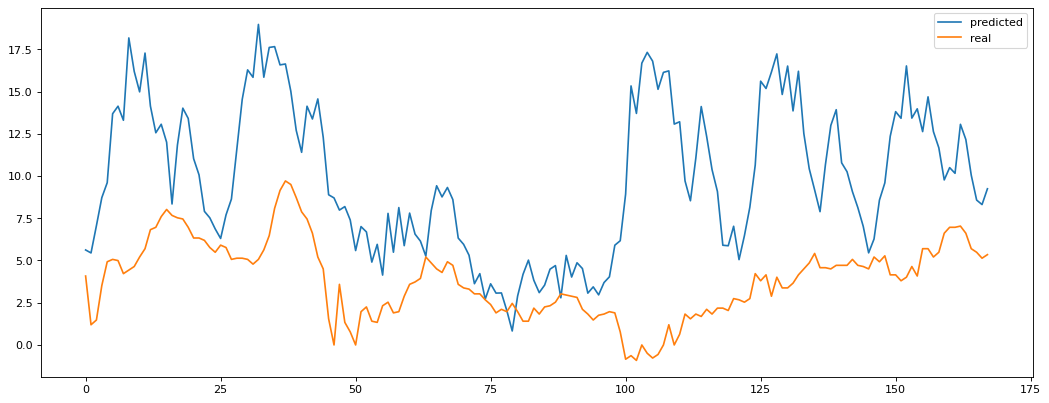

In [256]:
from matplotlib.pyplot import figure

figure(figsize=(16, 6), dpi=80)

plt.plot(range(len(pred[-168:])), scaler_y.inverse_transform(pred[-168:].reshape(-1, 1)), label='predicted')
plt.plot(range(len(ETT_y_val[-168:])), ETT_y_val[-168:], label='real')
plt.legend()

# Dataset 2. Electricity Consuming Load. 

In [221]:
ECL = get_Electricity_Consuming_Load_dataset()
#ECL=ECL.drop('MT_182', axis=1)

ECL_X, ECL_y = ECL.loc[:, ECL.columns != 'MT_320'], ECL['MT_320'].values.reshape(-1, 1)


ECL_X_train, ECL_X_test, ECL_y_train, ECL_y_test = train_test_split(ECL_X, ECL_y, test_size=0.3, shuffle=False)

ECL_X_val, ECL_X_test, ECL_y_val, ECL_y_test = train_test_split(ECL_X_test, ECL_y_test, test_size=0.5, shuffle=False)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

ECL_X_train_scaled = scaler_x.fit_transform(ECL_X_train)
ECL_y_train_scaled = scaler_y.fit_transform(ECL_y_train)

ECL_X_val_scaled = scaler_x.transform(ECL_X_val)
ECL_y_val_scaled = scaler_y.transform(ECL_y_val)

ECL_X_test_scaled = scaler_x.transform(ECL_X_test)
ECL_y_test_scaled = scaler_y.transform(ECL_y_test)

# VARMAX model

It is the combination of VAR and MA. VAR is the linear combination of lagged values of order 'p' and MA uses the past forecast errors of order 'q' in a regression-like mode . As like VAR, this model is also used for multile variables forecast at same time. To find the optimal parameters (p and q), we will use auto_arima() function.



In [224]:
from statsmodels.tsa.api import SARIMAX

model = SARIMAX(endog=ECL_y_train_scaled, 
                            exog=ECL_X_train_scaled, 
                            order=(1, 0, 1), 
                            #trend='c', 
                            disp=True)
model_result = model.fit(maxiter=1000, disp=True)

C:\Users\yul.a.yakimova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model_result.save(f'ECL_SARIMAX.pickle')

In [218]:
sliding_window = SlidingWindowDataset(np.hstack([ECL_X_val_scaled, ECL_y_val_scaled]), window_size=input_size + horizont_size, step_size=10)

In [225]:
list_mse=[]
list_mae=[]
list_mse_orig_measure = []
list_mae_orig_measure = []

start = len(ECL_X_train_scaled)
end = len(ECL_X_train_scaled) + len(ECL_X_val_scaled)


list_mse_naive = []
list_mae_naive = []
list_mse_naive_orig_measure = []
list_mae_naive_orig_measure = []

for i in range(len(sliding_window)):
    sample_x, sample_y = sliding_window[i][:, 0:-1], sliding_window[i][:, -1].reshape(-1, 1)

    past_target = sample_y[:336]
    target = sample_y[336:]
    past_cov = sample_x[:336]
    future_cov=sample_x[336:]

    model_result.apply(endog=past_target, exog=past_cov)

    pred = model_result.predict(exog=future_cov)
    naive_predict = np.ones(168) * past_target[-1]

    mse_orig_measure = mean_squared_error(scaler_y.inverse_transform(pred[-168:].reshape(-1, 1)), scaler_y.inverse_transform(target).reshape(-1, 1))
    mae_orig_measure = mean_absolute_error(scaler_y.inverse_transform(pred[-168:].reshape(-1, 1)), scaler_y.inverse_transform(target).reshape(-1, 1))
    
    mse = mean_squared_error(pred[-168:], target)
    mae = mean_absolute_error(pred[-168:], target)

    mse_naive = mean_squared_error(naive_predict[-168:], target)
    mae_naive = mean_absolute_error(naive_predict[-168:], target)

    mse_naive_orig_measure = mean_squared_error(scaler_y.inverse_transform(naive_predict[-168:].reshape(-1, 1)), scaler_y.inverse_transform(target).reshape(-1, 1))
    mae_naive_orig_measure = mean_absolute_error(scaler_y.inverse_transform(naive_predict[-168:].reshape(-1, 1)), scaler_y.inverse_transform(target).reshape(-1, 1))

    list_mse.append(mse)
    list_mae.append(mae)

    list_mse_orig_measure.append(mse_orig_measure)
    list_mae_orig_measure.append(mae_orig_measure)

    list_mse_naive.append(mse_naive)
    list_mae_naive.append(mae_naive)

    list_mse_naive_orig_measure.append(mse_naive_orig_measure)
    list_mae_naive_orig_measure.append(mae_naive_orig_measure)

print(f'Average MSE sarimax (scaled): {sum(list_mse) / len(list_mse)}')
print(f'Average MAE sarimax (scaled): {sum(list_mae) / len(list_mae)}')
print(f'Average MSE sarimax (original measure): {sum(list_mse_orig_measure) / len(list_mse_orig_measure)}')
print(f'Average MAE sarimax (original measure): {sum(list_mae_orig_measure) / len(list_mae_orig_measure)}')
print()

print(f'Average MSE naive (scaled): {sum(list_mse_naive) / len(list_mse_naive)}')
print(f'Average MAE naive (scaled): {sum(list_mae_naive) / len(list_mae_naive)}')
print(f'Average MSE naive (original measure): {sum(list_mse_naive_orig_measure) / len(list_mse_naive_orig_measure)}')
print(f'Average MAE naive (original measure): {sum(list_mae_naive_orig_measure) / len(list_mae_naive_orig_measure)}')


Average MSE sarimax (scaled): 1.4297720001738001
Average MAE sarimax (scaled): 0.9042240516475442
Average MSE sarimax (original measure): 439496.14005852974
Average MAE sarimax (original measure): 501.3259591697848
Average MSE naive (scaled): 1.661255157530073
Average MAE naive (scaled): 0.9732142092883944
Average MSE naive (original measure): 510651.5089804823
Average MAE naive (original measure): 539.5759447674421


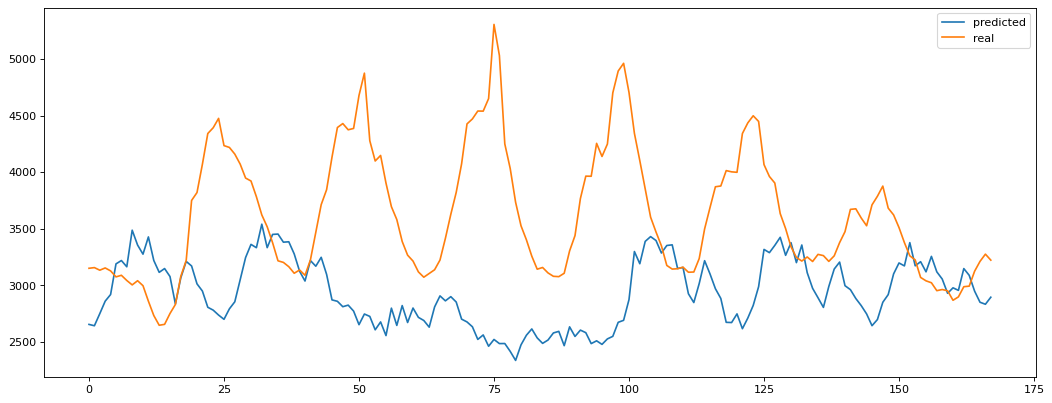

In [247]:
from matplotlib.pyplot import figure

figure(figsize=(16, 6), dpi=80)

plt.plot(range(len(pred[-168:])), scaler_y.inverse_transform(pred[-168:].reshape(-1, 1)), label='predicted')
plt.plot(range(len(ECL_y_val[-168:])), ECL_y_val[-168:], label='real')
plt.legend()